# Comparación de PHL con otros métodos de selección de instancias

In [26]:
import pandas as pd
import numpy as np
import time
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score

from data_reduction.representativeness import find_epsilon

sys.path.append('../')
from my_dataset_reduction import phl_selection, srs_selection, clc_selection, drop3_selection, cnn_selection

import seaborn as sns
import matplotlib.pyplot as plt


dbpath = '../datasets/dry+bean+dataset/DryBeanDataset/Dry_Bean_Dataset.xlsx'
target = 'Class'


SEED = 2025
np.random.seed(SEED)

PROFILING = False # False para tomar todo el dataset, True para tomar una muestra para hacer pruebas rápidas
results_folder = '../results/drybeans/' if not PROFILING else '../results/drybeans_profiling/'

# Check if the results folder exists, if not create it
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [27]:
df = pd.read_excel(dbpath, )

pd.set_option('display.max_columns', None)
print("Tamaño del dataset: ", df.shape)
df.describe()

Tamaño del dataset:  (13611, 17)


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.064220,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.177120,0.049086,0.004660,0.059520,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,1.432307,0.715928,36714.500000,215.068003,0.718634,0.985670,0.832096,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,1.551124,0.764441,45178.000000,238.438026,0.759859,0.988283,0.883157,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,1.707109,0.810466,62294.000000,279.446467,0.786851,0.990013,0.916869,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860153,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


In [28]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


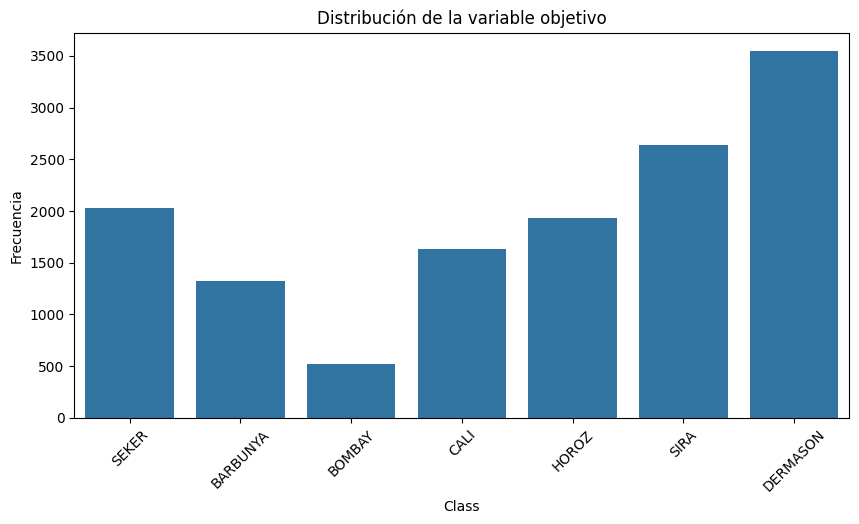

In [29]:
# Show bar plot of the target variable
plt.figure(figsize=(10, 5))
sns.countplot(x=target, data=df)
plt.title('Distribución de la variable objetivo')
plt.xlabel(target)
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [30]:
if PROFILING:
    df = df.sample(1000, random_state=SEED)

In [31]:
# Train test split
X = df.drop(columns=[target])
X = np.array(X)

# Convertir la columna target a entero
if not pd.api.types.is_integer_dtype(df[target]):
    le = LabelEncoder()
    y = le.fit_transform(df[target])
else:
    y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [32]:
# Modelos ML
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
xgb = XGBClassifier(n_estimators=100, random_state=SEED)

## Comparación de métodos de selección de instancias

In [33]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

results = pd.read_csv(results_folder + '/results.csv')

In [34]:
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.918840,0.919008,0.001117,0.000000
1,RF,None,1.00,1.000000,0.000000,0.922879,0.922812,3.392707,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.920676,0.920778,0.545556,0.000000
3,KNN,CNN,0.00,0.002388,8.825238,0.706941,0.687727,0.000388,0.263280
4,KNN,DROP3,0.00,0.074210,11.428036,0.916636,0.916788,0.000550,78.354272
...,...,...,...,...,...,...,...,...,...
109,RF,PHL V0 k=5,0.75,0.750000,13.615975,0.915167,0.914973,2.234588,2.275079
110,XGB,PHL V0 k=5,0.75,0.750000,13.615975,0.919207,0.919211,0.429668,2.275079
111,KNN,PHL V0 k=5,0.90,0.900073,11.690158,0.918105,0.918232,0.000870,2.301824
112,RF,PHL V0 k=5,0.90,0.900073,11.690158,0.918105,0.918194,2.837674,2.301824


/tmp/ipykernel_59852/989913642.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


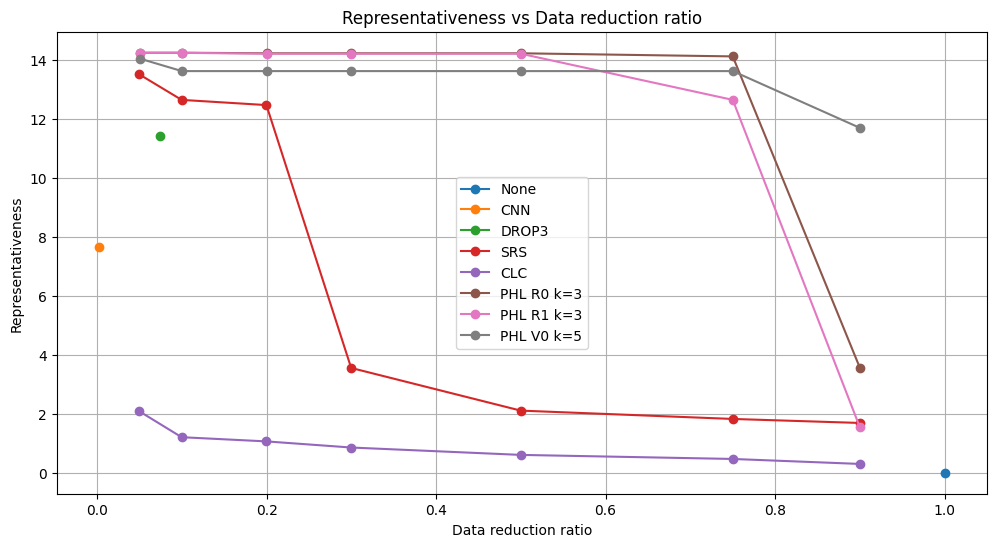

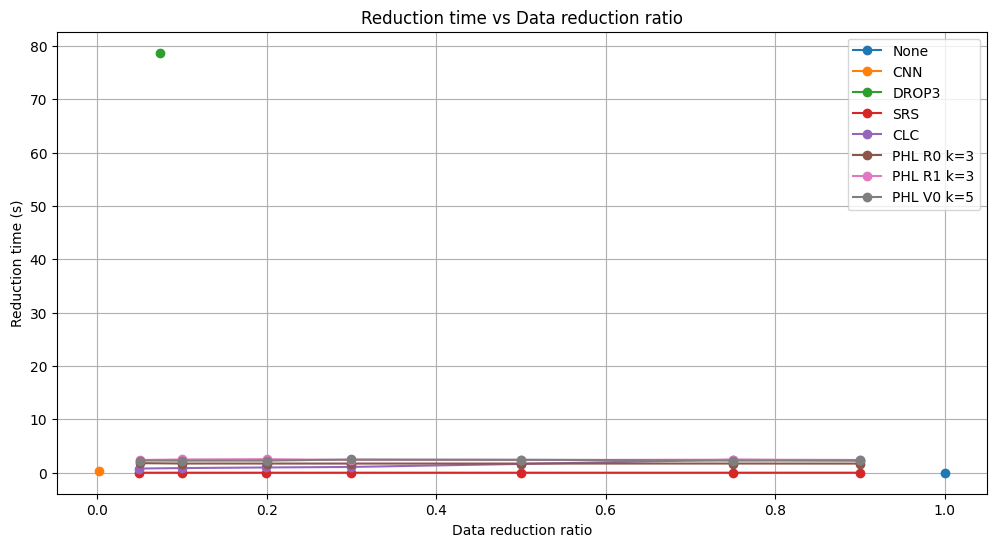

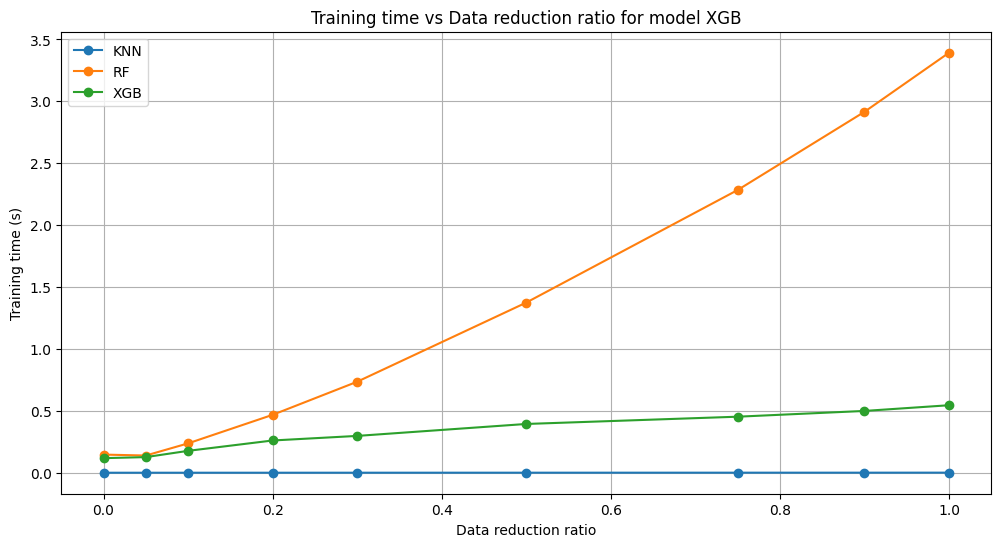

In [35]:
mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()
mean_training_time = results.groupby(['model', 'percentage'])['training_time'].mean().reset_index()

# Plot representativeness vs percentage averaged by model
plt.figure(figsize=(12, 6))
for reduction_method in results['reduction_method'].unique():
    plt.plot(mean_results[mean_results['reduction_method'] == reduction_method]['reduction_ratio'],
             mean_results[mean_results['reduction_method'] == reduction_method]['representativeness'],
             label=reduction_method, marker='o')
plt.title(f'Representativeness vs Data reduction ratio')
plt.xlabel('Data reduction ratio')
plt.ylabel('Representativeness')
plt.legend()
plt.grid()
# plt.savefig(f'{results_folder}/representativeness_vs_reduction_ratio.png')
plt.show()

# Plot reduction time vs percentage averaged by model
plt.figure(figsize=(12, 6))
for reduction_method in results['reduction_method'].unique():
    plt.plot(mean_results[mean_results['reduction_method'] == reduction_method]['reduction_ratio'],
             mean_results[mean_results['reduction_method'] == reduction_method]['reduction_time'],
             label=reduction_method, marker='o')
plt.title(f'Reduction time vs Data reduction ratio')
plt.xlabel('Data reduction ratio')
plt.ylabel('Reduction time (s)')
plt.legend()
plt.grid()
# plt.savefig(f'{results_folder}/reduction_time_vs_reduction_ratio.png')
plt.show()

# Plot training time vs percentage averaged by reduction method
plt.figure(figsize=(12, 6))
mean_training_time
for model_name in results['model'].unique():
    plt.plot(mean_training_time[mean_training_time['model'] == model_name]['percentage'],
             mean_training_time[mean_training_time['model'] == model_name]['training_time'],
             label=model_name, marker='o')
plt.title(f'Training time vs Data reduction ratio for model {model_name}')
plt.xlabel('Data reduction ratio')
plt.ylabel('Training time (s)')
plt.legend()
plt.grid()
# plt.savefig(f'{results_folder}/training_time_vs_percentage.png')
plt.show()


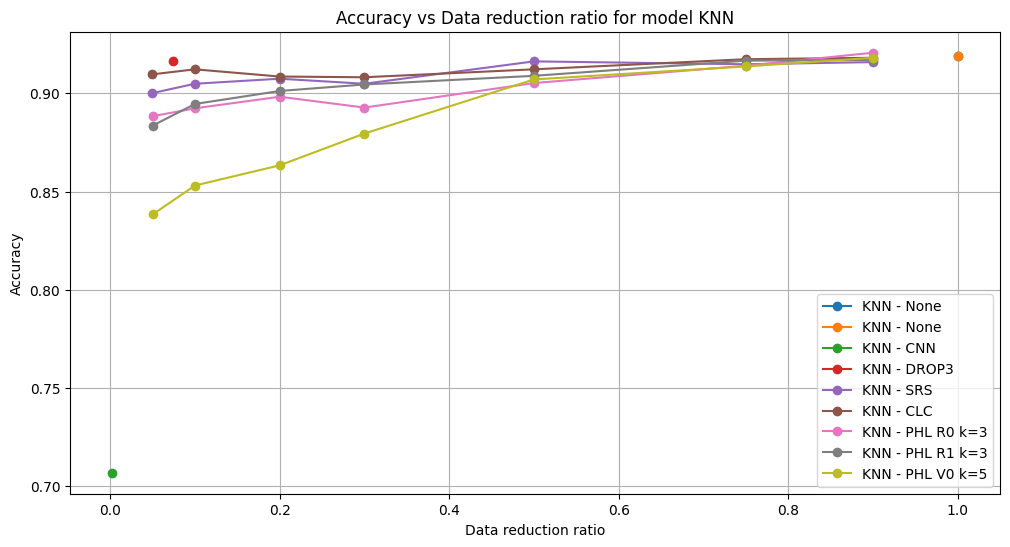

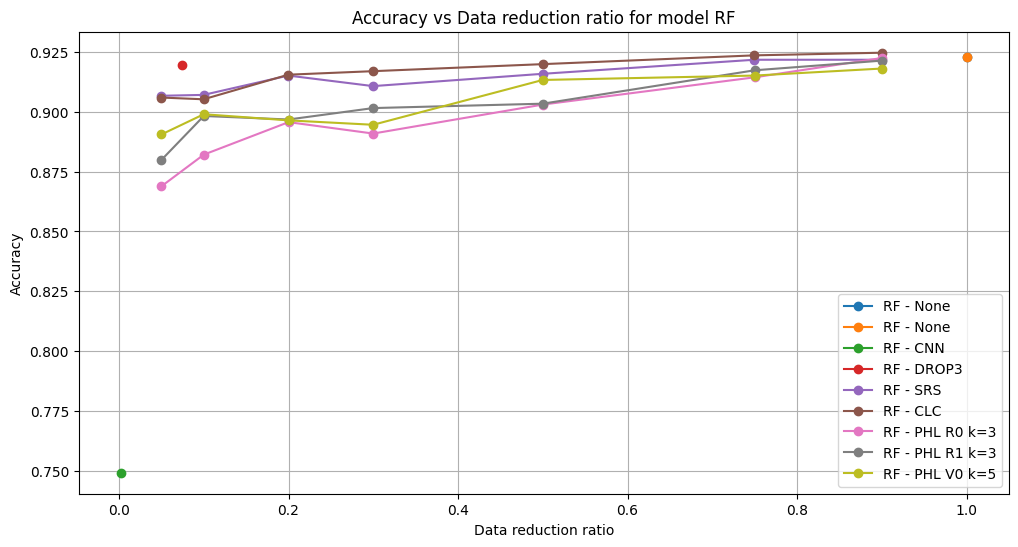

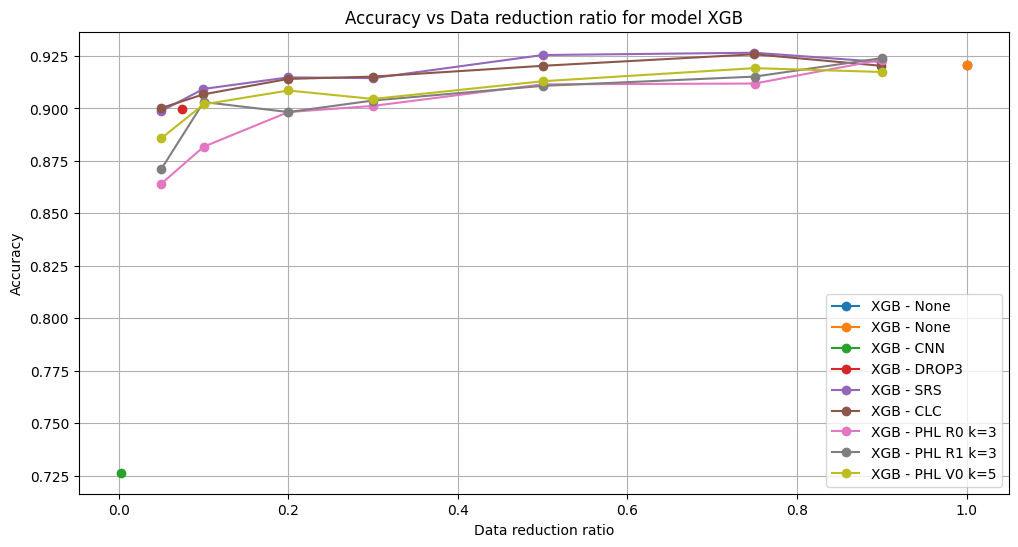

In [36]:
for model_name in results['model'].unique():
    plt.figure(figsize=(12, 6))
    plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
             results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['accuracy'],
             label=f'{model_name} - None', marker='o')
    for reduction_method in results['reduction_method'].unique():
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                 results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['accuracy'],
                 label=f'{model_name} - {reduction_method}', marker='o')
    plt.title(f'Accuracy vs Data reduction ratio for model {model_name}')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/accuracy_vs_percentage_{model_name}.png')
    plt.show()


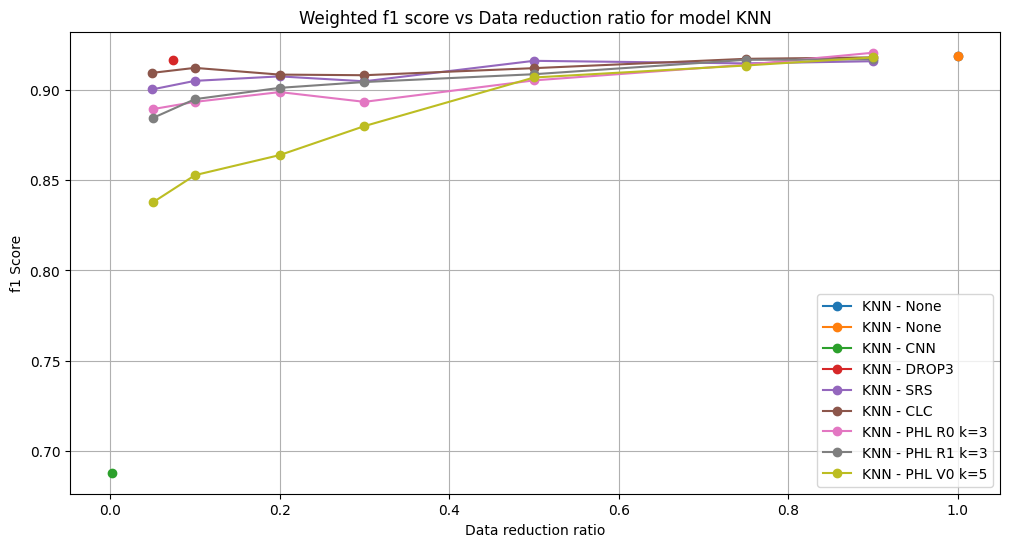

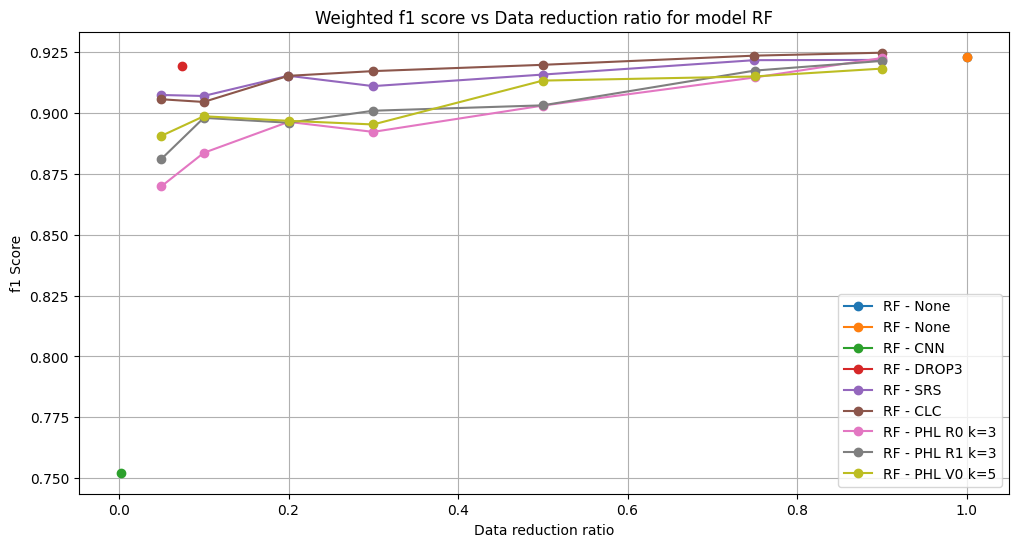

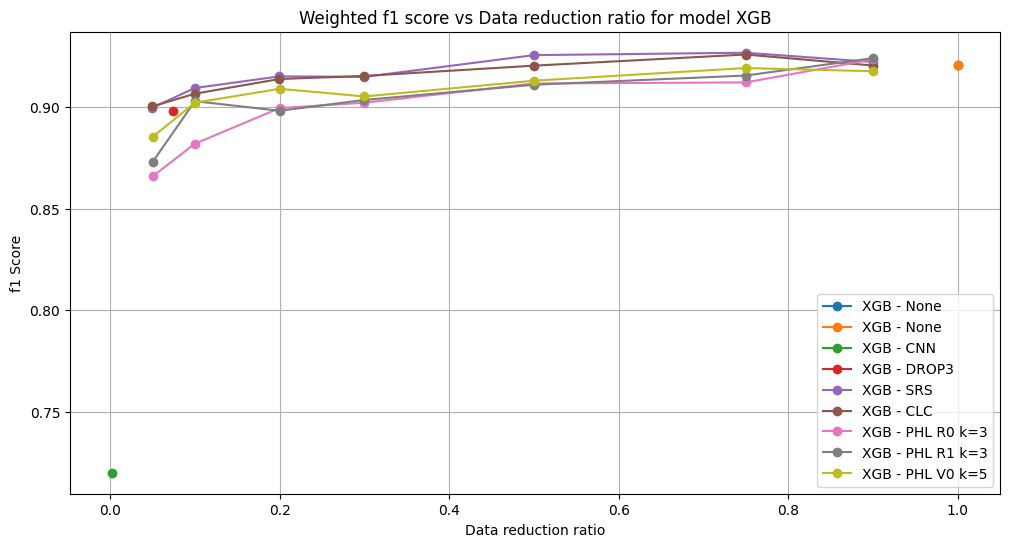

In [37]:
for model_name in results['model'].unique():
    plt.figure(figsize=(12, 6))
    plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
             results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['f1'],
             label=f'{model_name} - None', marker='o')
    for reduction_method in results['reduction_method'].unique():
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                 results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['f1'],
                 label=f'{model_name} - {reduction_method}', marker='o')
    plt.title(f'Weighted f1 score vs Data reduction ratio for model {model_name}')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('f1 Score')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/f1_vs_reduction_ratio_{model_name}.png')
    plt.show()
